In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from mordred import Calculator, descriptors

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

### Анализ данных

**Чтение данных**

In [5]:
def chunk_read_csv(file_path : str, chunk_size: int):
    df = pd.DataFrame()
    with pd.read_csv(file_path, chunksize=chunk_size) as reader:
        df = pd.concat(reader)
    return df

In [222]:
# Загрузка таблицы
# file_path = '../data/data_withMissFlag_fill-999_and_duplicates.csv'
file_path = '../data/data_withDropNA_and_duplicates.csv'
df = chunk_read_csv(file_path, chunk_size=200)
df

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.15910
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.67430
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.53610
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.95100
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.21300
...,...,...,...,...,...
15000,S=C(NN=C(c1ccccn1)c1ccccn1)Nc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314ed50>,24,3.21560
15001,S=C=NCCCCCCCCCCc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314edc0>,19,5.45270
15002,S=C=NCCCCCCCCc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314ee30>,17,4.67250
15003,S=c1[nH]nc(Cn2ccc3ccccc32)n1-c1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314eea0>,22,3.93289


### Преобразование данных

Добавим численные значение из библиотеки RDKit

In [223]:
# Преобразование SMILES в RDKit Mol объекты
df["nmol"]            = df["SMILES"].apply(Chem.MolFromSmiles)
df["MolecularWeight"] = df["nmol"].apply(lambda mol: Descriptors.MolWt(mol))
df["HBD"]             = df["nmol"].apply(lambda mol: rdMolDescriptors.CalcNumHBD(mol))
df["HBA"]             = df["nmol"].apply(lambda mol: rdMolDescriptors.CalcNumHBA(mol))
df["TPSA"]            = df["nmol"].apply(lambda mol: Descriptors.TPSA(mol))
df["RotatableBonds"]  = df["nmol"].apply(lambda mol: Descriptors.NumRotatableBonds(mol))
df["NumRings"]        = df["nmol"].apply(lambda mol: Descriptors.RingCount(mol))

In [224]:
df.head()

,SMILES,pIC50,mol,num_atoms,logP,nmol,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591,<rdkit.Chem.rdchem.Mol object at 0x00000230685...,367.455,1,5,71.95,4,4
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743,<rdkit.Chem.rdchem.Mol object at 0x00000230681...,506.434,4,6,149.78,7,5
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361,<rdkit.Chem.rdchem.Mol object at 0x00000230681...,317.389,3,5,101.37,5,3
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510,<rdkit.Chem.rdchem.Mol object at 0x00000230681...,301.394,3,5,98.96,5,3
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130,<rdkit.Chem.rdchem.Mol object at 0x00000230681...,294.383,2,3,49.84,2,3


In [225]:
calc = Calculator(descriptors)

In [226]:
%%time

chunk_size = 500
num_chunks = len(df) // chunk_size + 1
mordred_descs = []
for i in range(0, num_chunks):
    mordred_descs.append(calc.pandas(df.nmol[chunk_size*i : chunk_size*(i + 1)], quiet=True, ipynb=True))
    print(f"Посчитан чанк {i} из {num_chunks}, размер чанка {chunk_size}")
mordred_desc = pd.concat(mordred_descs)

Посчитан чанк 0 из 31, размер чанка 500
Посчитан чанк 1 из 31, размер чанка 500
D:\ProgramingPrograms\Python\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Посчитан чанк 2 из 31, размер чанка 500
D:\ProgramingPrograms\Python\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Посчитан чанк 3 из 31, размер чанка 500
Посчитан чанк 4 из 31, размер чанка 500
Посчитан чанк 5 из 31, размер чанка 500
Посчитан чанк 6 из 31, размер чанка 500
Посчитан чанк 7 из 31, размер чанка 500
Посчитан чанк 8 из 31, размер чанка 500
Посчитан чанк 9 из 31, размер чанка 500
Посчитан чанк 10 из 31, размер чанка 500
Посчитан чанк 11 из 31, размер чанка 500
D:\ProgramingPrograms\Python\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, a

In [227]:
mordred_desc.shape

(15005, 1826)

**Преобразование типов**

В новых данных некоторые столбцы имеют тип object, хотя в них содержаться числовые данные.

Чтобы не терять эти данные преобразуем тип object к типу float и удалим столбцы, где есть пустые значения (или что-то непонятное, например, выводы ошибки при вычислении дескриптора)

In [228]:
# Преобразуем проблемные столбцы
for col in mordred_desc.columns:
    if mordred_desc[col].dtype == object:
        mordred_desc[col] = pd.to_numeric(mordred_desc[col], errors='coerce')

# Заменяем бесконечные значения
# df = df.replace([np.inf, -np.inf], np.nan)

# Удаляем столбцы с >50% пропусков
# mordred_des = mordred_desc.dropna(axis=1, thresh=len(mordred_desc)*0.5)
mordred_desc = mordred_desc.dropna(axis=1)
mordred_desc.shape

(15005, 1088)

---
---
---

In [229]:
# Сохраним дескрипторы для тестов
mord_desc_test = mordred_desc 

In [230]:
# Сохраним данные со SMILES
dft = df.drop(columns=['mol', 'nmol'])

In [231]:
dft_values = dft.drop(columns=['SMILES'])

In [232]:
dft.head()

,SMILES,pIC50,num_atoms,logP,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591,367.455,1,5,71.95,4,4
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743,506.434,4,6,149.78,7,5
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361,317.389,3,5,101.37,5,3
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510,301.394,3,5,98.96,5,3
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130,294.383,2,3,49.84,2,3


**Уменьшение размерности**

In [233]:
%%time

# Рассчет корреляционной матрицы
corr_matrix = mord_desc_test.corr(numeric_only=True).abs()

CPU times: total: 17.1 s
Wall time: 35 s


In [234]:
corr_matrix

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
nAcid,1.000000,0.001224,0.011443,0.009289,0.001480,0.011443,0.093357,0.004406,0.001539,0.018575,...,0.002990,0.017166,0.000647,0.021778,0.009730,0.014158,0.009045,0.013816,0.051609,0.001629
nBase,0.001224,1.000000,0.214763,0.079772,0.082499,0.214763,0.080737,0.204854,0.179441,0.202258,...,0.142317,0.189857,0.201790,0.121461,0.178149,0.172016,0.203151,0.191438,0.159934,0.217466
SpAbs_A,0.011443,0.214763,1.000000,0.621867,0.629127,1.000000,0.425259,0.946337,0.903035,0.878731,...,0.807101,0.901620,0.953112,0.148552,0.855138,0.958472,0.989263,0.978201,0.846101,0.989559
SpMax_A,0.009289,0.079772,0.621867,1.000000,0.972578,0.621867,0.462199,0.759044,0.666907,0.739587,...,0.936002,0.730627,0.606283,0.033280,0.354722,0.719003,0.682827,0.715026,0.540940,0.566222
SpDiam_A,0.001480,0.082499,0.629127,0.972578,1.000000,0.629127,0.425917,0.772922,0.699580,0.758505,...,0.946343,0.664583,0.620227,0.031084,0.361629,0.730933,0.685658,0.713506,0.571119,0.581946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WPol,0.014158,0.172016,0.958472,0.719003,0.730933,0.958472,0.356373,0.916909,0.887528,0.836809,...,0.847159,0.879994,0.935643,0.082931,0.811610,1.000000,0.980795,0.987550,0.876395,0.939414
Zagreb1,0.009045,0.203151,0.989263,0.682827,0.685658,0.989263,0.388987,0.944153,0.907402,0.865556,...,0.842489,0.918942,0.954986,0.108590,0.842227,0.980795,1.000000,0.996935,0.863276,0.968858
Zagreb2,0.013816,0.191438,0.978201,0.715026,0.713506,0.978201,0.403243,0.935555,0.899850,0.851537,...,0.854374,0.923233,0.943014,0.095599,0.824549,0.987550,0.996935,1.000000,0.849359,0.950920
mZagreb1,0.051609,0.159934,0.846101,0.540940,0.571119,0.846101,0.017536,0.817235,0.790666,0.782896,...,0.708213,0.736556,0.902534,0.039675,0.786279,0.876395,0.863276,0.849359,1.000000,0.884271


In [239]:
# Удаление высоко коррелированных признаков
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
mordred_desc_reduced = mord_desc_test.drop(to_drop, axis=1)

In [240]:
mordred_desc_reduced.shape

(15005, 580)

Удаление высоко коррелированных признаков:

0,95: (, 1088) -> (, 579) 

In [306]:
from sklearn.preprocessing import StandardScaler

# Стандартизация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mordred_desc_reduced)
scaled_features.shape

(15005, 580)

In [415]:
# Удаление почти-константных признаков (Удаление низковариативных признаков)
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-5)
scaled_features = vt.fit_transform(scaled_features)
scaled_features.shape

(15005, 471)

Удаление почти-константных признаков (вариант)

- При стандартизации данных: (16054, 579) -> (16054, 475)
- Без стандартизации данных: (16054, 579) -> (16054, 475)

Ничего не поменялось, значит без разницы до или после 

In [416]:
from sklearn.decomposition import PCA

# PCA с сохранением 95% дисперсии
pca = PCA(n_components=150, svd_solver='randomized', random_state=42)
pca_features = pca.fit_transform(scaled_features)

# Создание DataFrame с компонентами
pca_df = pd.DataFrame(pca_features, columns=[f"PC_{i}" for i in range(pca_features.shape[1])])
pca_features.shape

(15005, 150)

In [417]:
# pca_df

In [425]:
# Подбор оптимального параметра n_components
np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.50)

0

In [426]:
import umap

# Инициализация и применение UMAP
um = umap.UMAP(n_components=3, random_state=42)  # Подберите n_components
umap_features = um.fit_transform(pca_features)

# Создание DataFrame
umap_df = pd.DataFrame(umap_features, columns=[f"UMAP_{i}" for i in range(umap_features.shape[1])])
umap_features.shape

D:\ProgramingPrograms\Python\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(15005, 3)

**Обучение модели**

In [249]:
scaled_dft_values = scaler.fit_transform(dft_values)

In [250]:
scaled_dft_values.shape

(15005, 9)

In [316]:
umap_features.shape

(15005, 7)

In [427]:
X = np.concatenate((dft_values, umap_features), axis=1)
X.shape

(15005, 12)

In [428]:
# Оценки для k-means алгоритма

n_clast = (2, 30)

silhouette_scores = []
db_scores = []
ch_scores = []
inertias = []
for k in range(n_clast[0], n_clast[1]):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)

    silhouette_scores.append(silhouette_score(X, labels))

    db_scores.append(davies_bouldin_score(X, labels))

    ch_scores.append(calinski_harabasz_score(X, labels))

    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

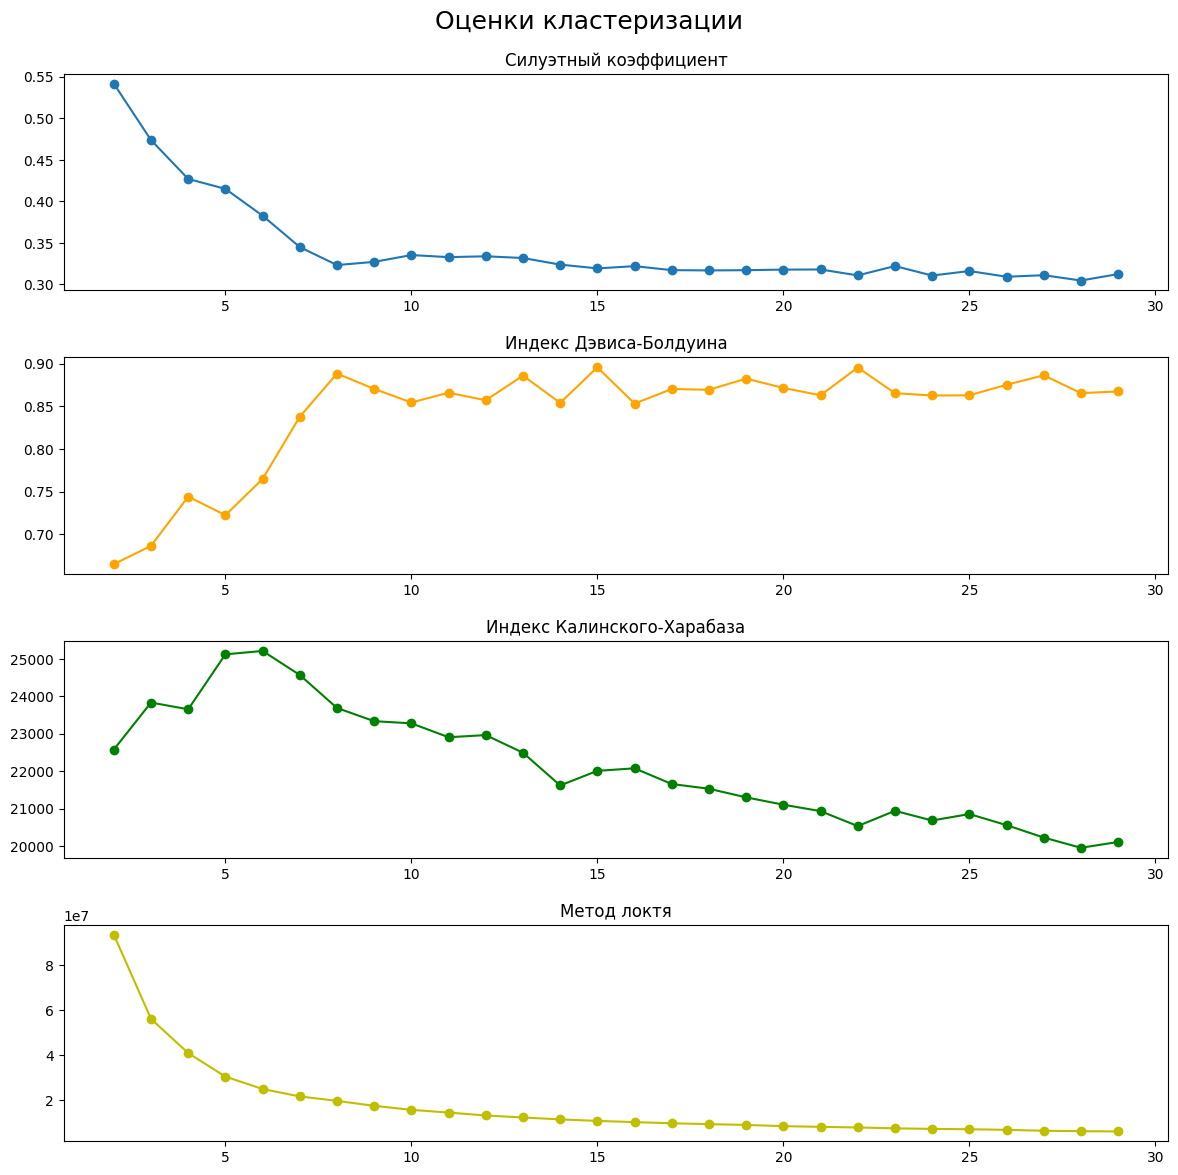

In [429]:
fig, ax = plt.subplots(4, figsize=(12, 12))
fig.suptitle('Оценки кластеризации', fontsize=18)
ax[0].plot(range(n_clast[0], n_clast[1]), silhouette_scores, marker='o')
ax[0].set_title('Силуэтный коэффициент')
ax[1].plot(range(n_clast[0], n_clast[1]), db_scores, marker='o', color='orange')
ax[1].set_title('Индекс Дэвиса-Болдуина')
ax[2].plot(range(n_clast[0], n_clast[1]), ch_scores, marker='o', color='g')
ax[2].set_title('Индекс Калинского-Харабаза')
ax[3].plot(range(n_clast[0], n_clast[1]), inertias, marker='o', color='y')
ax[3].set_title('Метод локтя')
fig.tight_layout(pad=1.5)
plt.show()

**HDBSCAN**

In [436]:
import hdbscan

# HDBSCAN
clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon_max=0.1)
labels = clusterer.fit_predict(X)

# Оценки

sil = silhouette_score(X, labels)
db = davies_bouldin_score(X[labels != -1], labels[labels != -1])

print("sil:", sil, "db:", db, "n:", len(np.unique(labels)))
# print(np.unique(labels))

D:\ProgramingPrograms\Python\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\ProgramingPrograms\Python\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


sil: 0.024208136101601753 db: 0.49045489386025604 n: 3


**❤️ DBSCAN**

In [433]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Кластеризация
# dbscan = DBSCAN(eps=0, min_samples=100)
dbscan = DBSCAN(eps=0.3)
clusters_db = dbscan.fit_predict(X)

# Оценка качества (игнорируем шумовые точки)
if len(np.unique(clusters_db)) > 1:
    sil = silhouette_score(X[clusters_db != -1], clusters_db[clusters_db != -1])
    db = davies_bouldin_score(X[clusters_db != -1], clusters_db[clusters_db != -1])
    ch = calinski_harabasz_score(X[clusters_db != -1], clusters_db[clusters_db != -1])
    print("Силуэтный коэффициент:", sil, "\nИндекс Дэвиса-Болдуина:", db, "\nИндекс Калинского-Харабаза:", ch, "\nКол-во кластеров:", len(np.unique(clusters_db)))
else:
    print("Все данные отнесены к шуму или одному кластеру.")

Силуэтный коэффициент: 0.9563943915479872 
Индекс Дэвиса-Болдуина: 0.06082083137090833 
Индекс Калинского-Харабаза: 2411106.9686279637 
Кол-во кластеров: 26


In [434]:
counts = np.bincount(clusters_db + 1, minlength=len(np.unique(clusters_db)) + 1)  # от -1 до 10 включительно = 12 чисел
counts

array([14751,     5,    15,     5,     5,     6,    15,    24,    29,
          22,    11,     8,    13,     5,     5,     5,    13,     9,
          16,     8,     6,     7,     6,     5,     5,     6,     0],
      dtype=int64)

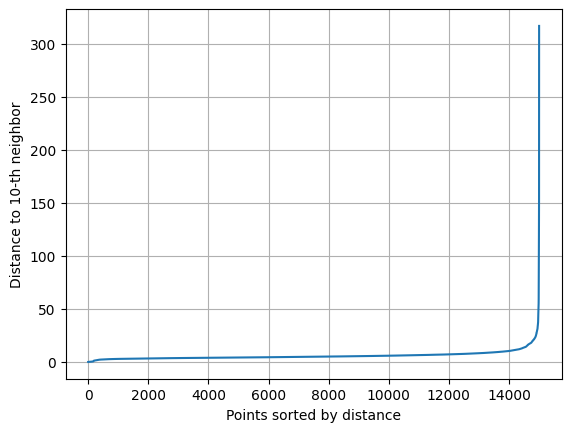

In [437]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# X_emb — матрица, на которой ты запускаешь DBSCAN (UMAP или PCA)
k = 10  # обычно = min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
k_distances = np.sort(distances[:, -1])  # расстояние до k-го соседа, отсортированное

plt.plot(k_distances)
plt.ylabel(f"Distance to {k}-th neighbor")
plt.xlabel("Points sorted by distance")
plt.grid(True)
plt.show()

In [410]:
def show_clusters_means(df, clusters):
    cluster_means = pd.DataFrame(df).groupby(clusters).mean()
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means.T, cmap='viridis', annot=True, fmt="3.1f")
    plt.title('Средние значения признаков по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Признак')
    plt.show()

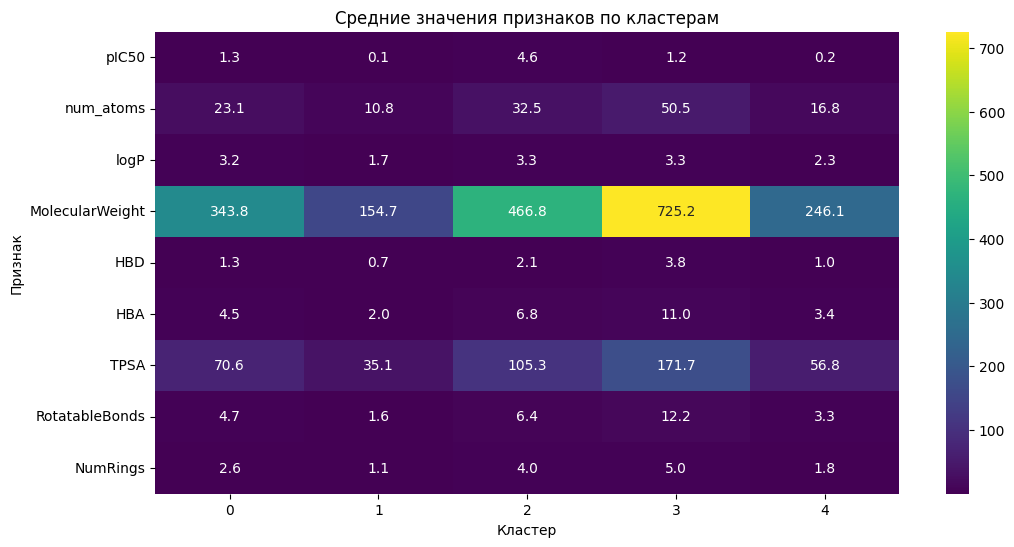

In [441]:
show_clusters_means(dft_values, labels)

**Дальнейшие действия**

Нужно как-то получить дескрипоры, которые мы оставили при уменьшении размерности 
Вроде бы эти столбцы сохраняются в виде свойства для каждого метода

scaler

varianceTreshHold

PCA

UMAP

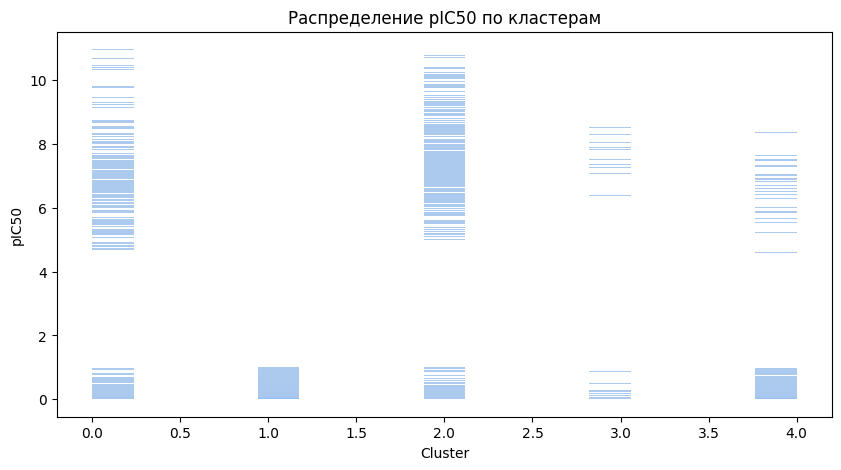

In [440]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(x="Cluster", y="pIC50", data=dft_result)
plt.title("Распределение pIC50 по кластерам")
plt.show()

Почему то присутствует неравномерное распределение св-ва pIC50. Обычно есть кластер где содержиться больше элементов чем в остальных

In [438]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(X)
clusters_db_df = pd.DataFrame(labels, columns=["Cluster"])

In [383]:
clusters_db_df = pd.DataFrame(clusters_db.T, columns=["Cluster"])

In [439]:
dft_result = pd.concat([dft_values, clusters_db_df], axis=1)

In [362]:
dft_result

,pIC50,num_atoms,logP,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings,Cluster
0,4.26,25,4.15910,367.455,1,5,71.95,4,4,0
1,4.34,36,3.67430,506.434,4,6,149.78,7,5,5
2,4.53,23,1.53610,317.389,3,5,101.37,5,3,0
3,4.56,22,0.95100,301.394,3,5,98.96,5,3,0
4,4.59,21,3.21300,294.383,2,3,49.84,2,3,6
...,...,...,...,...,...,...,...,...,...,...
15000,0.00,24,3.21560,333.420,2,4,62.20,4,3,0
15001,0.00,19,5.45270,275.461,0,2,12.36,11,1,6
15002,0.00,17,4.67250,247.407,0,2,12.36,9,1,6
15003,0.00,22,3.93289,306.394,1,4,38.54,3,4,0


In [279]:
dft_result.describe()

,pIC50,num_atoms,logP,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings,Cluster
count,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000
mean,0.995791,18.931490,2.465248,276.228444,1.139820,3.752016,61.236614,3.634722,2.100966,20.540953
std,2.475348,8.444723,1.441981,118.694703,1.118441,2.387376,37.665155,2.992135,1.377351,60.243524
min,0.000000,3.000000,-0.404900,40.065000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,13.000000,1.414200,189.174000,0.000000,2.000000,34.140000,1.000000,1.000000,-1.000000
50%,0.010000,17.000000,2.282800,257.318000,1.000000,3.000000,56.790000,3.000000,2.000000,-1.000000
75%,0.130000,23.000000,3.308900,343.415000,2.000000,5.000000,85.360000,5.000000,3.000000,-1.000000
max,10.970000,85.000000,15.879200,1202.635000,10.000000,20.000000,288.280000,32.000000,9.000000,284.000000


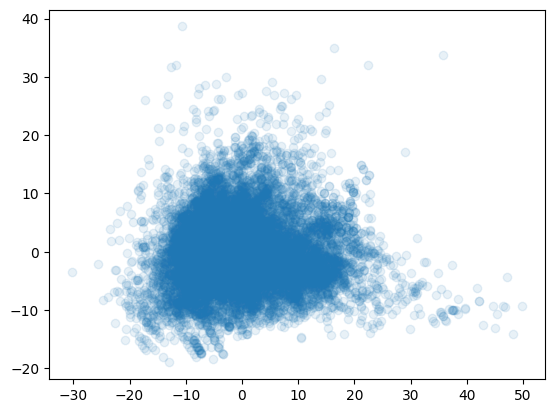

In [280]:
# 2D PCA
pca_vis = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(mordred_des_reduced))
plt.scatter(pca_vis[:,0], pca_vis[:,1], alpha=0.1)